In [3]:
# P/glade/ core
from typing import Optional, Callable, TypedDict, Union, Dict
import yaml

# Scientific python
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# PyTorch
import torch
from torchvision import transforms

# distributed bridgescaler:
from bridgescaler import read_scaler


import logging

logger = logging.getLogger(__name__)

import logging
from credit.data import Sample

## ERA5 Dataset

In [2]:
class ERA5Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        filenames: list = [
            "/glade/derecho/scratch/wchapman/STAGING/TOTAL_2012-01-01_2012-12-31_staged.zarr",
            "/glade/derecho/scratch/wchapman/STAGING/TOTAL_2013-01-01_2013-12-31_staged.zarr",
        ],
        history_len: int = 1,
        forecast_len: int = 2,
        transform: Optional[Callable] = None,
        seed=42,
        skip_periods=None,
        one_shot=None,
    ):
        self.history_len = history_len
        self.forecast_len = forecast_len
        self.transform = transform
        self.skip_periods = skip_periods
        self.one_shot = one_shot
        self.total_seq_len = self.history_len + self.forecast_len
        all_fils = []
        filenames = sorted(filenames)
        for fn in filenames:
            all_fils.append(get_forward_data(filename=fn))
        self.all_fils = all_fils
        self.data_array = all_fils[0]
        self.rng = np.random.default_rng(seed=seed)

        # set data places:
        indo = 0
        self.meta_data_dict = {}
        for ee, bb in enumerate(self.all_fils):
            self.meta_data_dict[str(ee)] = [
                len(bb["time"]),
                indo,
                indo + len(bb["time"]),
            ]
            indo += len(bb["time"]) + 1

        # set out of bounds indexes...
        OOB = []
        for kk in self.meta_data_dict.keys():
            OOB.append(generate_integer_list_around(self.meta_data_dict[kk][2]))
        self.OOB = flatten_list(OOB)

    def __post_init__(self):
        # Total sequence length of each sample.
        self.total_seq_len = self.history_len + self.forecast_len

    def __len__(self):
        tlen = 0
        for bb in self.all_fils:
            tlen += len(bb["time"]) - self.total_seq_len + 1
        return tlen

    def __getitem__(self, index):
        # find the result key:
        result_key = find_key_for_number(index, self.meta_data_dict)
        # get the data selection:
        true_ind = index - self.meta_data_dict[result_key][1]

        if true_ind > (
            len(self.all_fils[int(result_key)]["time"])
            - (self.history_len + self.forecast_len + 1)
        ):
            true_ind = len(self.all_fils[int(result_key)]["time"]) - (
                self.history_len + self.forecast_len + 1
            )

        datasel = (
            self.all_fils[int(result_key)]
            .isel(
                time=slice(
                    true_ind, true_ind + self.history_len + self.forecast_len + 1
                )
            )
            .load()
        )

        if self.skip_periods is not None:
            sample = Sample(
                historical_ERA5_images=datasel.isel(
                    time=slice(0, self.history_len, self.skip_periods)
                ),
                target_ERA5_images=datasel.isel(
                    time=slice(
                        self.history_len, len(datasel["time"]), self.skip_periods
                    )
                ),
                datetime_index=datasel.time.values.astype("datetime64[s]").astype(int),
            )
        elif self.one_shot is not None:
            total_seq_len = self.history_len + self.forecast_len + 1
            sample = Sample(
                historical_ERA5_images=datasel.isel(time=slice(0, self.history_len)),
                target_ERA5_images=datasel.isel(
                    time=slice(total_seq_len - 1, total_seq_len)
                ),
                datetime_index=datasel.time.values.astype("datetime64[s]").astype(int),
            )
        else:
            sample = Sample(
                historical_ERA5_images=datasel.isel(time=slice(0, self.history_len)),
                target_ERA5_images=datasel.isel(
                    time=slice(self.history_len, len(datasel["time"]))
                ),
                datetime_index=datasel.time.values.astype("datetime64[s]").astype(int),
            )

        if self.transform:
            sample = self.transform(sample)
        return sample

## Transforms

In [193]:
class NormalizeState:
    def __init__(self, conf):
        self.mean_ds = xr.open_dataset(conf["data"]["mean_path"])
        self.std_ds = xr.open_dataset(conf["data"]["std_path"])
        self.variables = conf["data"]["variables"]
        self.surface_variables = conf["data"]["surface_variables"]
        self.levels = conf["model"]["levels"]

        logger.info(
            "Loading preprocessing object for transform/inverse transform states into z-scores"
        )

    def __call__(self, sample: Sample, inverse: bool = False) -> Sample:
        if inverse:
            return self.inverse_transform(sample)
        else:
            return self.transform(sample)

    def transform_array(self, x: torch.Tensor) -> torch.Tensor:
        device = x.device
        tensor = x[:, : (len(self.variables) * self.levels), :, :]
        surface_tensor = x[:, (len(self.variables) * self.levels) :, :, :]

        # Reverse z-score normalization using the pre-loaded mean and std
        transformed_tensor = tensor.clone()
        k = 0
        for name in self.variables:
            for level in range(self.levels):
                mean = self.mean_ds[name].values[level]
                std = self.std_ds[name].values[level]
                transformed_tensor[:, k] = (tensor[:, k] - mean) / std
                k += 1

        transformed_surface_tensor = surface_tensor.clone()
        for k, name in enumerate(self.surface_variables):
            mean = self.mean_ds[name].values
            std = self.std_ds[name].values
            transformed_surface_tensor[:, k] = (surface_tensor[:, k] - mean) / std

        transformed_x = torch.cat(
            (transformed_tensor, transformed_surface_tensor), dim=1
        )

        return transformed_x.to(device)

    def transform(self, sample: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        normalized_sample = {}
        for key, value in sample.items():
            if isinstance(value, xr.Dataset):
                normalized_sample[key] = (value - self.mean_ds) / self.std_ds
        return normalized_sample

    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        device = x.device
        tensor = x[:, : (len(self.variables) * self.levels), :, :]
        surface_tensor = x[:, (len(self.variables) * self.levels) :, :, :]

        # Reverse z-score normalization using the pre-loaded mean and std
        transformed_tensor = tensor.clone()
        k = 0
        for name in self.variables:
            for level in range(self.levels):
                mean = self.mean_ds[name].values[level]
                std = self.std_ds[name].values[level]
                transformed_tensor[:, k] = tensor[:, k] * std + mean
                k += 1

        transformed_surface_tensor = surface_tensor.clone()
        for k, name in enumerate(self.surface_variables):
            mean = self.mean_ds[name].values
            std = self.std_ds[name].values
            transformed_surface_tensor[:, k] = surface_tensor[:, k] * std + mean

        transformed_x = torch.cat(
            (transformed_tensor, transformed_surface_tensor), dim=1
        )

        return transformed_x.to(device)


class ToTensor:
    def __init__(self, conf):
        self.conf = conf
        self.hist_len = int(conf["data"]["history_len"])
        self.for_len = int(conf["data"]["forecast_len"])
        self.variables = conf["data"]["variables"]
        self.surface_variables = conf["data"]["surface_variables"]
        self.allvars = self.variables + self.surface_variables
        self.static_variables = conf["data"]["static_variables"]

    def __call__(self, sample: Sample) -> Sample:
        return_dict = {}

        for key, value in sample.items():
            if key == "historical_ERA5_images":
                self.doy = value["time.dayofyear"]
                self.hod = value["time.hour"]

            if isinstance(value, xr.DataArray):
                value_var = value.values

            elif isinstance(value, xr.Dataset):
                surface_vars = []
                concatenated_vars = []
                for vv in self.allvars:
                    value_var = value[vv].values
                    if vv in self.surface_variables:
                        surface_vars_temp = value_var
                        surface_vars.append(surface_vars_temp)
                    else:
                        concatenated_vars.append(value_var)
                surface_vars = np.array(surface_vars)
                concatenated_vars = np.array(concatenated_vars)

            else:
                value_var = value

            if key == "historical_ERA5_images" or key == "x":
                x_surf = torch.as_tensor(surface_vars).squeeze()
                return_dict["x_surf"] = (
                    x_surf.permute(1, 0, 2, 3)
                    if len(x_surf.shape) == 4
                    else x_surf.unsqueeze(0)
                )
                return_dict["x"] = torch.as_tensor(
                    np.hstack([np.expand_dims(x, axis=1) for x in concatenated_vars])
                )

            elif key == "target_ERA5_images" or key == "y":
                y_surf = torch.as_tensor(surface_vars)
                y = torch.as_tensor(
                    np.hstack([np.expand_dims(x, axis=1) for x in concatenated_vars])
                )
                return_dict["y_surf"] = y_surf.permute(1, 0, 2, 3)
                return_dict["y"] = y

        if self.static_variables:
            DSD = xr.open_dataset(self.conf["loss"]["latitude_weights"])
            arrs = []
            for sv in self.static_variables:
                if sv == "tsi":
                    TOA = xr.open_dataset(self.conf["data"]["TOA_forcing_path"])
                    times_b = pd.to_datetime(TOA.time.values)
                    mask_toa = [
                        (time.dayofyear in self.doy) and (time.hour in self.hod)
                        for time in times_b
                    ]
                    return_dict["TOA"] = (TOA[sv].sel(time=mask_toa)) / (2540585.74)
                    # return_dict['TOA'] = torch.tensor(((TOA[sv].sel(time=mask_toa))/(2540585.74)).to_numpy())
                if sv == "SP":
                    arr = 2 * torch.tensor(
                        np.array(
                            (
                                (DSD["SP"] - DSD["SP"].max())
                                / (DSD["SP"].min() - DSD["SP"].max())
                            )
                        )
                    )
                else:
                    try:
                        arr = DSD[sv].squeeze()
                    except:
                        continue
                arrs.append(arr)

            return_dict["static"] = np.stack(arrs, axis=0)

        return return_dict

## Functions

In [188]:
Array = Union[np.ndarray, xr.DataArray]
IMAGE_ATTR_NAMES = ("historical_ERA5_images", "target_ERA5_images")


def get_forward_data(filename) -> xr.DataArray:
    """Lazily opens the Zarr store on gladefilesystem."""
    dataset = xr.open_zarr(filename, consolidated=True)
    return dataset


class Sample(TypedDict):
    """Simple class for structuring data for the ML model.

    Using typing.TypedDict gives us several advantages:
      1. Single 'source of truth' for the type and documentation of each example.
      2. A static type checker can check the types are correct.

    Instead of TypedDict, we could use typing.NamedTuple,
    which would provide runtime checks, but the deal-breaker with Tuples is that they're immutable
    so we cannot change the values in the transforms.
    """

    # IMAGES
    # Shape: batch_size, seq_length, lat, lon, lev
    historical_ERA5_images: Array
    target_ERA5_images: Array

    # METADATA
    datetime_index: Array


def get_forward_data(filename) -> xr.DataArray:
    """Lazily opens the Zarr store on gladefilesystem."""
    dataset = xr.open_zarr(filename, consolidated=True)
    return dataset


def generate_integer_list_around(number, spacing=10):
    """
    Generate a list of integers on either side of a given number with a specified spacing.

    Parameters:
    - number (int): The central number around which the list is generated.
    - spacing (int): The spacing between consecutive integers in the list. Default is 10.

    Returns:
    - integer_list (list): List of integers on either side of the given number.
    """
    lower_limit = number - spacing
    upper_limit = number + spacing + 1  # Adding 1 to include the upper limit
    integer_list = list(range(lower_limit, upper_limit))

    return integer_list


def flatten_list(list_of_lists):
    """
    Flatten a list of lists.

    Parameters:
    - list_of_lists (list): A list containing sublists.

    Returns:
    - flattened_list (list): A flattened list containing all elements from sublists.
    """
    return [item for sublist in list_of_lists for item in sublist]


def find_key_for_number(input_number, data_dict):
    """
    Find the key in the dictionary based on the given number.

    Parameters:
    - input_number (int): The number to search for in the dictionary.
    - data_dict (dict): The dictionary with keys and corresponding value lists.

    Returns:
    - key_found (str): The key in the dictionary where the input number falls within the specified range.
    """
    for key, value_list in data_dict.items():
        if value_list[1] <= input_number <= value_list[2]:
            return key

    # Return None if the number is not within any range
    return None

## Config File

In [4]:
# Load the configuration and get the relevant variables
config = "/glade/work/wchapman/miles_branchs/pull_Mar30_2024/config//crossformer.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

## Test Normal Transform

In [213]:
import glob

FNS = sorted(glob.glob("/glade/derecho/scratch/schreck/STAGING/TOTAL_*"))

In [196]:
%%time
nunu = 17
m_path = "/glade/derecho/scratch/schreck/STAGING/All_2010_staged.mean.Lev.SLO.nc"
s_path = "/glade/derecho/scratch/schreck/STAGING/All_2010_staged.std.Lev.SLO.nc"
history_len = 2
forecast_len = 0

Dataset = ERA5Dataset(
    filenames=FNS,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=1,
    transform=transforms.Compose(
        [
            NormalizeState(conf),
            ToTensor(conf),
        ]
    ),
)
BB_trancs = Dataset.__getitem__(10062)
print("done")
Dataset = ERA5Dataset(
    filenames=FNS,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=1,
    transform=transforms.Compose(
        [
            NormalizeState(conf),
        ]
    ),
)
BB_trancs_no_tens = Dataset.__getitem__(100603)

done
CPU times: user 6.83 s, sys: 1.19 s, total: 8.02 s
Wall time: 4.28 s


In [400]:
%%time
nunu = 17
m_path = "/glade/derecho/scratch/schreck/STAGING/All_2010_staged.mean.Lev.SLO.nc"
s_path = "/glade/derecho/scratch/schreck/STAGING/All_2010_staged.std.Lev.SLO.nc"
history_len = 2
forecast_len = 0

Dataset = ERA5Dataset(
    filenames=FNS,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=1,
    transform=transforms.Compose(
        [
            NormalizeState_Quantile(conf),
            ToTensor(conf),
        ]
    ),
)

BB_trancs = Dataset.__getitem__(100603)
print("done")

done
CPU times: user 12.3 s, sys: 893 ms, total: 13.2 s
Wall time: 11.5 s


In [548]:
class NormalizeState_Quantile:
    """Class to use the bridgescaler Quantile functionality.
    Some hoops have to be jumped thorugh, and the efficiency could be
    improved if we were to retrain the bridgescaler.
    """

    def __init__(self, conf):
        self.scaler_file = conf["data"]["quant_path"]
        self.variables = conf["data"]["variables"]
        self.surface_variables = conf["data"]["surface_variables"]
        self.levels = int(conf["model"]["levels"])
        self.scaler_df = pd.read_parquet(self.scaler_file)
        self.scaler_3ds = self.scaler_df["scaler_3d"].apply(read_scaler)
        self.scaler_surfs = self.scaler_df["scaler_surface"].apply(read_scaler)
        self.scaler_3d = self.scaler_3ds.sum()
        self.scaler_surf = self.scaler_surfs.sum()

        self.scaler_surf.channels_last = False
        self.scaler_3d.channels_last = False

    def __call__(self, sample: Sample, inverse: bool = False) -> Sample:
        if inverse:
            return self.inverse_transform(sample)
        else:
            return self.transform(sample)

    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        device = x.device
        tensor = x[:, : (len(self.variables) * self.levels), :, :]  # B, Var, H, W
        surface_tensor = x[
            :, (len(self.variables) * self.levels) :, :, :
        ]  # B, Var, H, W
        # beep
        # Reverse quantile transform using bridge scaler:
        transformed_tensor = tensor.clone()
        transformed_surface_tensor = surface_tensor.clone()
        # 3dvars
        rscal_3d = np.array(x[:, : (len(self.variables) * self.levels), :, :])

        transformed_tensor[:, :, :, :] = torch.tensor(
            (self.scaler_3d.inverse_transform(rscal_3d))
        ).to(device)
        # surf
        rscal_surf = np.array(x[:, (len(self.variables) * self.levels) :, :, :])
        transformed_surface_tensor[:, :, :, :] = torch.tensor(
            (self.scaler_surf.inverse_transform(rscal_surf))
        ).to(device)
        # cat them
        transformed_x = torch.cat(
            (transformed_tensor, transformed_surface_tensor), dim=1
        )
        # return
        return transformed_x.to(device)

    def transform(self, sample: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        normalized_sample = {}
        for key, value in sample.items():
            if isinstance(value, xr.Dataset):
                var_levels = []
                for var in self.variables:
                    levels = value.level.values
                    for level in levels:
                        var_levels.append(f"{var}_{level:d}")
                ds_times = value["time"].values
                for time in ds_times:
                    var_slices = []
                    for var in self.variables:
                        for level in levels:
                            var_slices.append(value[var].sel(time=time, level=level))

                    e3d = xr.concat(var_slices, pd.Index(var_levels, name="variable"))
                    e3d = e3d.expand_dims(dim="time", axis=0)

                    TTtrans = self.scaler_3d.transform(np.array(e3d))
                    # this is bad and should be fixed:
                    value["U"].sel(time=time)[:, :, :] = TTtrans[
                        :, : self.levels, :, :
                    ].squeeze()
                    value["V"].sel(time=time)[:, :, :] = TTtrans[
                        :, self.levels : (self.levels * 2), :, :
                    ].squeeze()
                    value["T"].sel(time=time)[:, :, :] = TTtrans[
                        :, (self.levels * 2) : (self.levels * 3), :, :
                    ].squeeze()
                    value["Q"].sel(time=time)[:, :, :] = TTtrans[
                        :, (self.levels * 3) : (self.levels * 4), :, :
                    ].squeeze()

                    e_surf = xr.concat(
                        [value[v].sel(time=time) for v in self.surface_variables],
                        pd.Index(self.surface_variables, name="variable"),
                    )
                    e_surf = e_surf.expand_dims(dim="time", axis=0)
                    TTtrans = self.scaler_surf.transform(e_surf)

                    for ee, varvar in enumerate(self.surface_variables):
                        value[varvar].sel(time=time)[:, :] = TTtrans[
                            0, ee, :, :
                        ].squeeze()
            normalized_sample[key] = value
        return normalized_sample

In [549]:
%%time
nunu = 17
m_path = "/glade/derecho/scratch/schreck/STAGING/All_2010_staged.mean.Lev.SLO.nc"
s_path = "/glade/derecho/scratch/schreck/STAGING/All_2010_staged.std.Lev.SLO.nc"
history_len = 2
forecast_len = 0

Dataset = ERA5Dataset(
    filenames=FNS,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=1,
    transform=transforms.Compose(
        [
            NormalizeState_Quantile(conf),
            ToTensor(conf),
        ]
    ),
)

BB_trancs = Dataset.__getitem__(100603)
print("done")
Bigboy = torch.reshape(BB_trancs["x"], (2, 60, 640, 1280))
Bigboy2 = BB_trancs["x_surf"]
Big_boy2 = torch.concatenate([Bigboy, Bigboy2], axis=1)

Bingo = NormalizeState_Quantile(conf)
GG = Bingo.inverse_transform(Big_boy2)

done
CPU times: user 15.9 s, sys: 1.23 s, total: 17.1 s
Wall time: 15.4 s


In [554]:
Big_boy2[0, 35, :, :].shape

torch.Size([640, 1280])

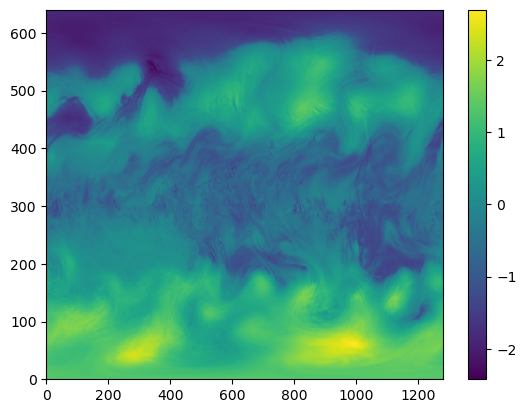

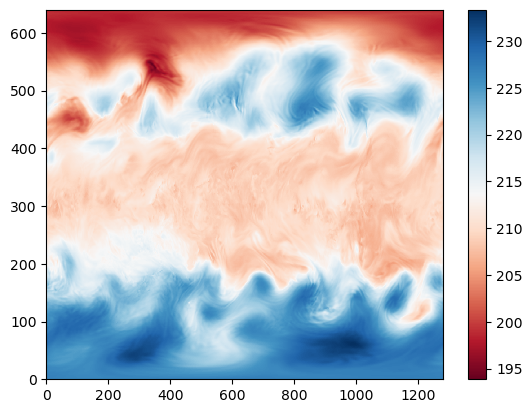

In [550]:
plt.pcolormesh(Big_boy2[0, 35, :, :])
plt.colorbar()
plt.show()

plt.pcolormesh(GG[0, 35, :, :], cmap="RdBu")
plt.colorbar()
plt.show()

## try inverse Tensor

In [561]:
%%time
scaler_3d_total.transform(np.random.rand(2, 60, 640, 1280))
print("done")

done
CPU times: user 4.68 s, sys: 248 ms, total: 4.92 s
Wall time: 4.98 s


In [562]:
%%time
scaler_3d_total.transform(np.random.rand(1, 60, 640, 1280))
scaler_3d_total.transform(np.random.rand(1, 60, 640, 1280))
print("done")

done
CPU times: user 4.65 s, sys: 245 ms, total: 4.9 s
Wall time: 4.98 s
